# 1 — Exploratory Data Analysis (EDA)

**Dataset:** AMELIA (*Argument Mining Evaluation on Legal documents in ItAlian*)  
**Task:** Classificazione binaria — *premise* (`prem`) vs *conclusion* (`conc`)  
**Obiettivo:** Comprendere distribuzione, proprietà lessicali e caratteristiche delle classi prima di addestrare i modelli.

In [1]:
import warnings

warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

DATASET_ID = "nlp-unibo/AMELIA"
print("Loading AMELIA dataset...")

Loading AMELIA dataset...


## 1.1 — Caricamento e panoramica

In [2]:
ds = load_dataset(DATASET_ID)

# Converti in DataFrame per ciascun split
dfs = {}
for split in ["train", "validation", "test"]:
    df = ds[split].to_pandas()
    df["split"] = split
    df["text_len_chars"] = df["Text"].str.len()
    df["text_len_words"] = df["Text"].str.split().str.len()
    dfs[split] = df

df_all = pd.concat(dfs.values(), ignore_index=True)

print(f"Totale campioni: {len(df_all)}")
print(f"Colonne: {list(df_all.columns)}")
print("\nCampioni per split:")
print(df_all.groupby("split").size().to_frame("count"))
print("\nPrime 3 righe:")
df_all[["Text", "Component", "split"]].head(3)

Totale campioni: 3311
Colonne: ['index', 'Document', 'Chain_id', 'Text', 'Split', 'Component', 'Type', 'Scheme', 'Id', 'split', 'text_len_chars', 'text_len_words']

Campioni per split:
            count
split            
test          594
train        2108
validation    609

Prime 3 righe:


,Text,Component,split
0,L’appello è infondato e va respinto,conc,train
1,Privo di fondamento appare il primo motivo di ...,prem,train
2,Infatti la sentenza richiamata esiste (Cass.n....,prem,train


## 1.2 — Distribuzione delle classi

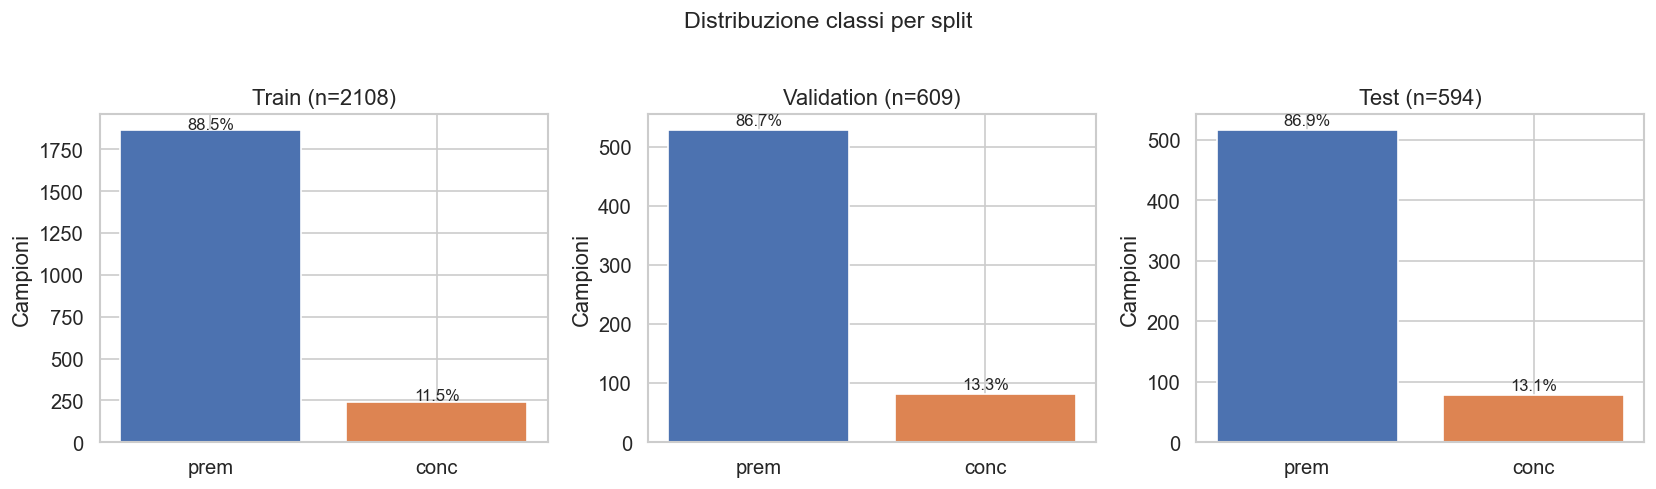


Rapporto prem/conc:
  train       : 7.7:1  (1866 prem, 242 conc)
  validation  : 6.5:1  (528 prem, 81 conc)
  test        : 6.6:1  (516 prem, 78 conc)


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, split in zip(axes, ["train", "validation", "test"]):
    counts = dfs[split]["Component"].value_counts()
    pct = counts / counts.sum() * 100
    bars = ax.bar(counts.index, counts.values, color=["#4C72B0", "#DD8452"])
    ax.set_title(f"{split.capitalize()} (n={counts.sum()})")
    ax.set_ylabel("Campioni")
    for bar, p in zip(bars, pct):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 8,
            f"{p:.1f}%",
            ha="center",
            fontsize=10,
        )

fig.suptitle("Distribuzione classi per split", fontsize=14, y=1.02)
fig.tight_layout()
plt.savefig("../results/plots/class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nRapporto prem/conc:")
for split in ["train", "validation", "test"]:
    counts = dfs[split]["Component"].value_counts()
    ratio = counts.get("prem", 0) / counts.get("conc", 1)
    print(
        f"  {split:12s}: {ratio:.1f}:1  ({counts.get('prem', 0)} prem, {counts.get('conc', 0)} conc)"
    )

## 1.3 — Distribuzione della lunghezza dei testi

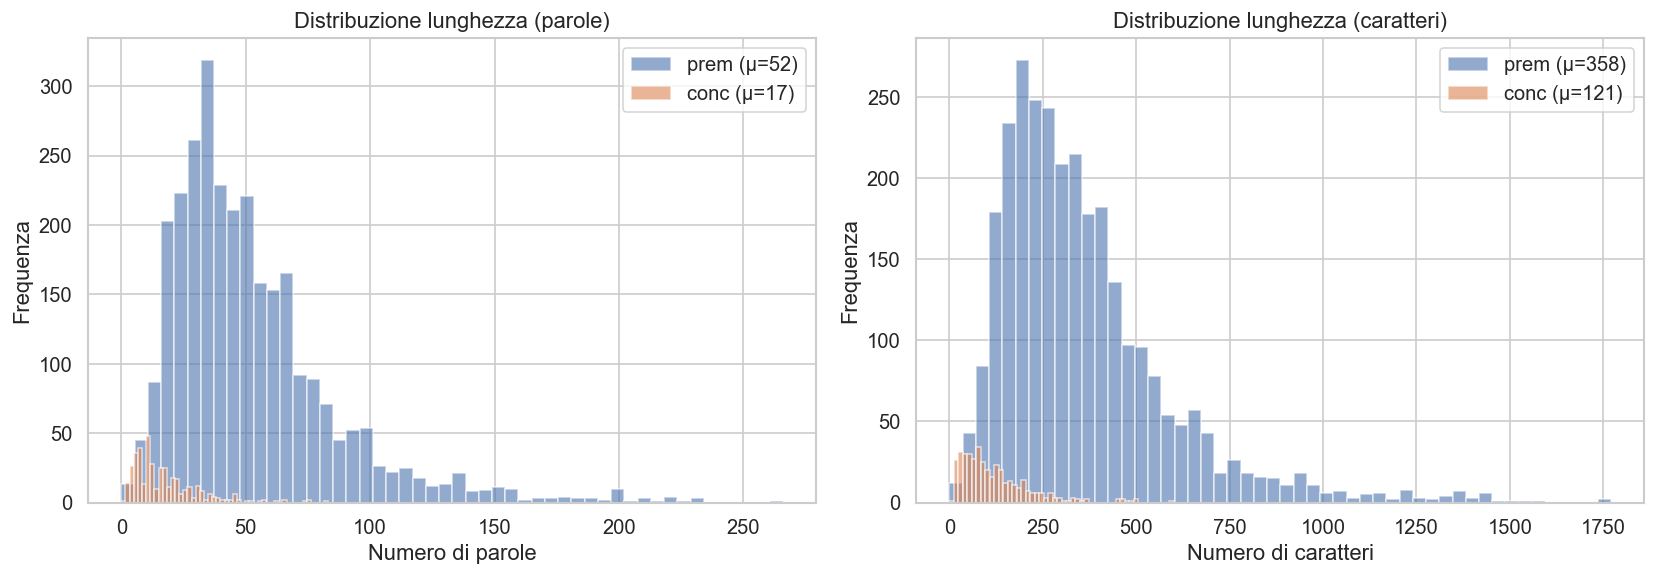


Statistiche lunghezza (parole):
            count  mean   std  min   25%   50%   75%    max
Component                                                  
conc        401.0  17.1  13.4  0.0   8.0  13.0  22.0   83.0
prem       2910.0  52.3  33.8  0.0  30.0  44.0  66.0  266.0


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lunghezza in parole
for label, color in [("prem", "#4C72B0"), ("conc", "#DD8452")]:
    subset = df_all[df_all["Component"] == label]
    axes[0].hist(
        subset["text_len_words"],
        bins=50,
        alpha=0.6,
        label=f"{label} (μ={subset['text_len_words'].mean():.0f})",
        color=color,
        edgecolor="white",
    )
axes[0].set_xlabel("Numero di parole")
axes[0].set_ylabel("Frequenza")
axes[0].set_title("Distribuzione lunghezza (parole)")
axes[0].legend()

# Lunghezza in caratteri
for label, color in [("prem", "#4C72B0"), ("conc", "#DD8452")]:
    subset = df_all[df_all["Component"] == label]
    axes[1].hist(
        subset["text_len_chars"],
        bins=50,
        alpha=0.6,
        label=f"{label} (μ={subset['text_len_chars'].mean():.0f})",
        color=color,
        edgecolor="white",
    )
axes[1].set_xlabel("Numero di caratteri")
axes[1].set_ylabel("Frequenza")
axes[1].set_title("Distribuzione lunghezza (caratteri)")
axes[1].legend()

fig.tight_layout()
plt.savefig("../results/plots/text_length_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nStatistiche lunghezza (parole):")
print(df_all.groupby("Component")["text_len_words"].describe().round(1))

## 1.4 — Analisi della tokenizzazione WordPiece (BERTino)

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indigo-ai/BERTino")
MAX_LENGTH = 256

# Tokenizza tutti i testi
all_texts = df_all["Text"].tolist()
encodings = tokenizer(all_texts, truncation=False, padding=False)
token_lengths = [len(ids) for ids in encodings["input_ids"]]
df_all["token_length"] = token_lengths

# Statistiche troncamento
n_truncated = sum(1 for tl in token_lengths if tl > MAX_LENGTH)
pct_truncated = n_truncated / len(token_lengths) * 100

print(f"Lunghezza massima in token: {max(token_lengths)}")
print(f"Lunghezza media: {np.mean(token_lengths):.1f} ± {np.std(token_lengths):.1f}")
print(f"Mediana: {np.median(token_lengths):.0f}")
print(
    f"\nSequenze troncate a max_length={MAX_LENGTH}: {n_truncated}/{len(token_lengths)} ({pct_truncated:.1f}%)"
)

Lunghezza massima in token: 399
Lunghezza media: 69.8 ± 50.0
Mediana: 58

Sequenze troncate a max_length=256: 40/3311 (1.2%)


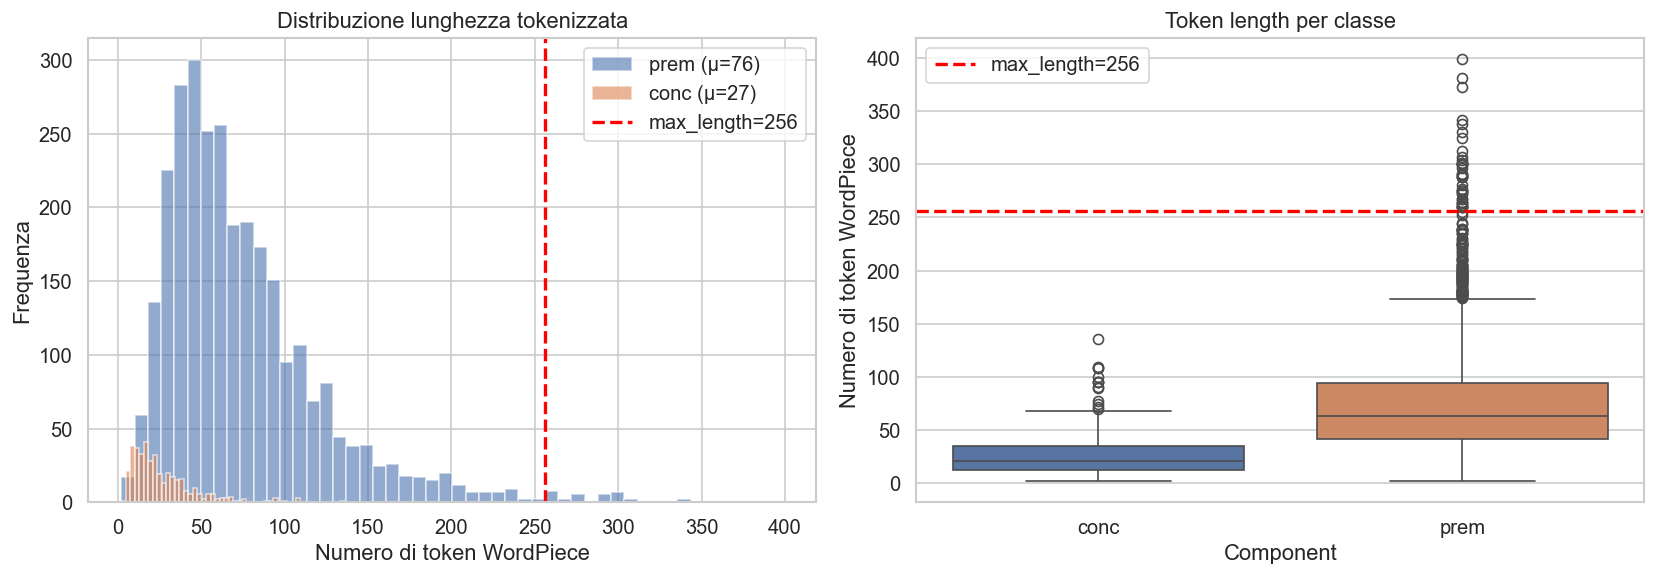

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuzione token per classe
for label, color in [("prem", "#4C72B0"), ("conc", "#DD8452")]:
    subset = df_all[df_all["Component"] == label]
    axes[0].hist(
        subset["token_length"],
        bins=50,
        alpha=0.6,
        label=f"{label} (μ={subset['token_length'].mean():.0f})",
        color=color,
        edgecolor="white",
    )
axes[0].axvline(
    x=MAX_LENGTH, color="red", linestyle="--", linewidth=2, label=f"max_length={MAX_LENGTH}"
)
axes[0].set_xlabel("Numero di token WordPiece")
axes[0].set_ylabel("Frequenza")
axes[0].set_title("Distribuzione lunghezza tokenizzata")
axes[0].legend()

# Box plot per classe
sns.boxplot(
    data=df_all, x="Component", y="token_length", ax=axes[1], palette=["#4C72B0", "#DD8452"]
)
axes[1].axhline(
    y=MAX_LENGTH, color="red", linestyle="--", linewidth=2, label=f"max_length={MAX_LENGTH}"
)
axes[1].set_title("Token length per classe")
axes[1].set_ylabel("Numero di token WordPiece")
axes[1].legend()

fig.tight_layout()
plt.savefig("../results/plots/token_length_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

## 1.5 — Top TF-IDF terms per classe

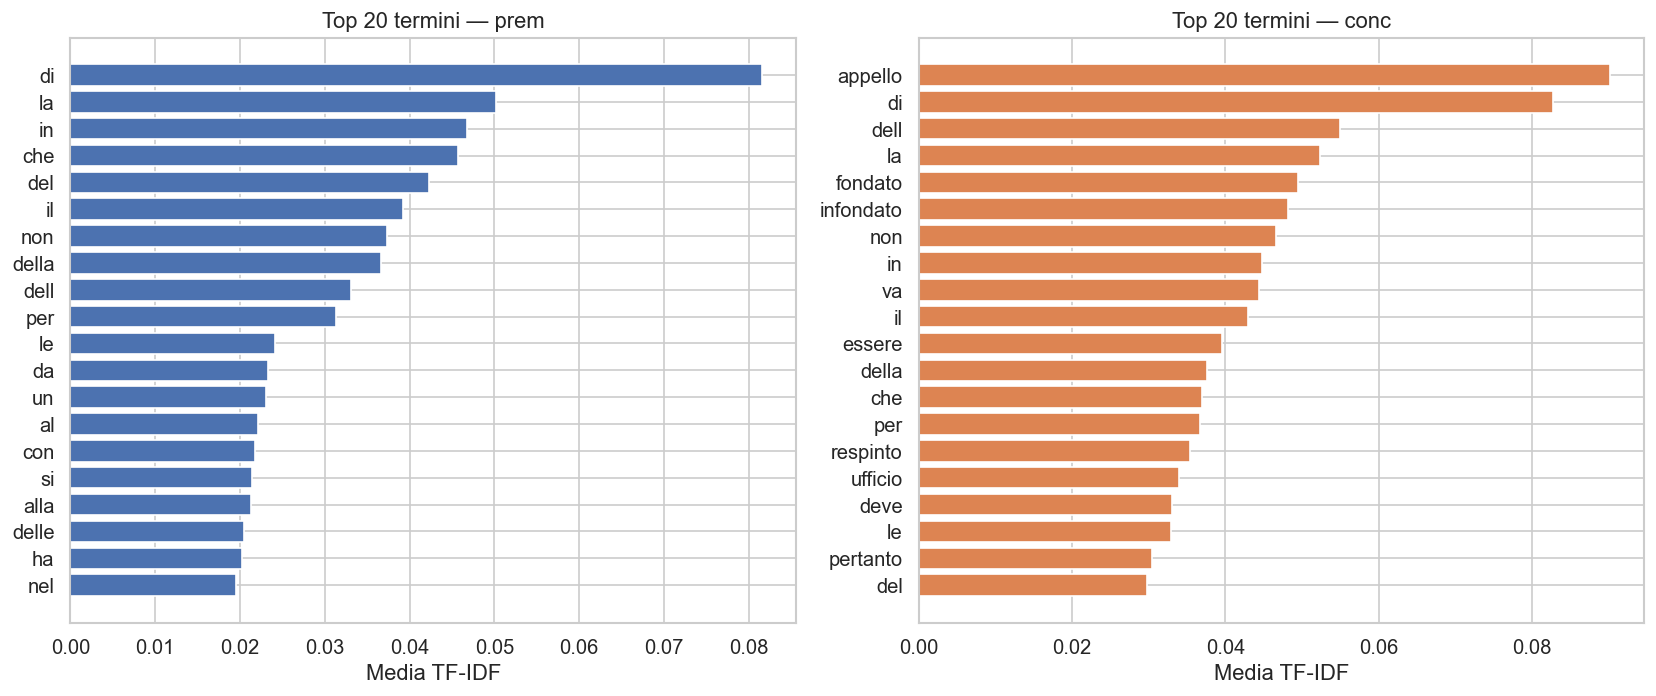

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_df = dfs["train"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, label, color in zip(axes, ["prem", "conc"], ["#4C72B0", "#DD8452"]):
    texts = train_df[train_df["Component"] == label]["Text"].tolist()
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 1), min_df=2)
    X = tfidf.fit_transform(texts)

    # Media TF-IDF per termine
    mean_tfidf = np.asarray(X.mean(axis=0)).flatten()
    feature_names = tfidf.get_feature_names_out()
    top_indices = mean_tfidf.argsort()[-20:][::-1]

    top_terms = [feature_names[i] for i in top_indices]
    top_scores = [mean_tfidf[i] for i in top_indices]

    ax.barh(range(len(top_terms)), top_scores, color=color)
    ax.set_yticks(range(len(top_terms)))
    ax.set_yticklabels(top_terms)
    ax.invert_yaxis()
    ax.set_xlabel("Media TF-IDF")
    ax.set_title(f"Top 20 termini — {label}")

fig.tight_layout()
plt.savefig("../results/plots/top_tfidf_terms.png", dpi=150, bbox_inches="tight")
plt.show()

## 1.6 — Word Cloud per classe

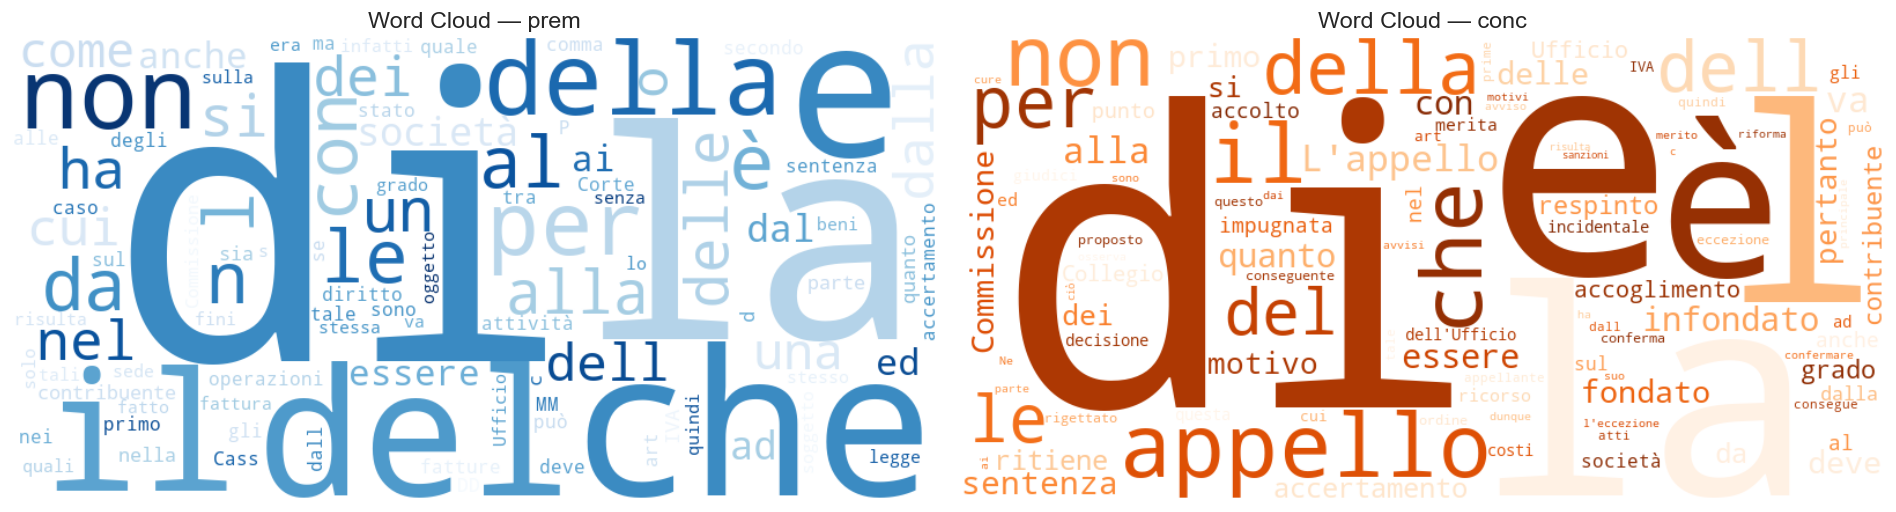

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, label, cmap in zip(axes, ["prem", "conc"], ["Blues", "Oranges"]):
    texts = " ".join(train_df[train_df["Component"] == label]["Text"].tolist())
    wc = WordCloud(
        width=800,
        height=400,
        max_words=100,
        colormap=cmap,
        background_color="white",
        collocations=False,
    ).generate(texts)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Word Cloud — {label}", fontsize=14)
    ax.axis("off")

fig.tight_layout()
plt.savefig("../results/plots/wordclouds.png", dpi=150, bbox_inches="tight")
plt.show()

## 1.7 — Overlap lessicale tra classi

In [9]:
# Vocabolario per classe (solo training)
prem_words = set()
conc_words = set()

for _, row in train_df.iterrows():
    words = set(row["Text"].lower().split())
    if row["Component"] == "prem":
        prem_words.update(words)
    else:
        conc_words.update(words)

overlap = prem_words & conc_words
only_prem = prem_words - conc_words
only_conc = conc_words - prem_words

print(f"Vocabolario premise:    {len(prem_words):,} parole uniche")
print(f"Vocabolario conclusion: {len(conc_words):,} parole uniche")
print(
    f"Overlap:                {len(overlap):,} parole ({len(overlap) / len(prem_words | conc_words) * 100:.1f}%)"
)
print(f"Solo in prem:           {len(only_prem):,}")
print(f"Solo in conc:           {len(only_conc):,}")
print('\n→ L"alto overlap lessicale spiega perché un modello BoW (TF-IDF) ha limiti: le due classi')
print(
    "  condividono la maggior parte del vocabolario. BERTino riesce a distinguere grazie al contesto."
)

Vocabolario premise:    14,754 parole uniche
Vocabolario conclusion: 1,328 parole uniche
Overlap:                1,096 parole (7.3%)
Solo in prem:           13,658
Solo in conc:           232

→ L"alto overlap lessicale spiega perché un modello BoW (TF-IDF) ha limiti: le due classi
  condividono la maggior parte del vocabolario. BERTino riesce a distinguere grazie al contesto.


## 1.8 — Riepilogo EDA

**Osservazioni chiave:**

1. **Sbilanciamento:** ~80% premise, ~20% conclusioni → Macro-F1 è la metrica corretta per non ignorare la classe minoritaria
2. **Lunghezza testi:** le premesse tendono ad essere più lunghe delle conclusioni (sia in parole che in token)
3. **Troncamento WordPiece:** solo una piccola percentuale dei testi supera `max_length=256` → la scelta è appropriata
4. **Overlap lessicale:** le due classi condividono gran parte del vocabolario → un modello BoW è penalizzato, un modello contestuale (BERTino) può sfruttare la struttura sintattica
5. **Top TF-IDF terms:** i termini più discriminanti riflettono il linguaggio giuridico-argomentativo